## Initial Local Creation of Bayesian Network

## HC + BIC

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [1]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data importing and preprocessing

In [2]:
loaded_data = myData.load_data()

#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, test_data = myData.split_data(data,num_rows = 10000)

feature_states = myData.get_feature_states(data)
display(data)

c:\Users\zachs\Documents\CSHons\ResearchReport\Research_Code\Honours-Research\HC_differentScores\..\Data\DataPreprocessing.py:14: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/accepted_2007_to_2018Q4.csv", engine='c')
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced w

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,"(961.0, 8800.0]",36 months,"(10.446, 15.582]","(5.898, 350.054]",C,10+ years,MORTGAGE,0.0,Not Verified,2015,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,N,Cash,N
1,"(24400.0, 32200.0]",36 months,"(10.446, 15.582]","(692.498, 1034.942]",C,10+ years,MORTGAGE,0.0,Not Verified,2015,...,0.0,4.0,0.0,0.0,0.0,0.0,3.0,N,Cash,N
2,"(16600.0, 24400.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",B,10+ years,MORTGAGE,0.0,Not Verified,2015,...,0.0,4.0,2.0,0.0,0.0,0.0,0.0,N,Cash,N
4,"(8800.0, 16600.0]",60 months,"(20.718, 25.854]","(5.898, 350.054]",F,3 years,MORTGAGE,1.0,Source Verified,2015,...,1.0,4.0,3.0,0.0,0.0,1.0,1.0,N,Cash,N
5,"(8800.0, 16600.0]",36 months,"(10.446, 15.582]","(350.054, 692.498]",C,4 years,RENT,0.0,Source Verified,2015,...,0.0,4.0,4.0,0.0,0.0,0.0,0.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,"(16600.0, 24400.0]",60 months,"(5.284, 10.446]","(350.054, 692.498]",B,5 years,OWN,1.0,Not Verified,2016,...,0.0,4.0,1.0,0.0,0.0,1.0,0.0,N,Cash,N
2260690,"(24400.0, 32200.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",C,9 years,MORTGAGE,1.0,Not Verified,2016,...,0.0,4.0,2.0,0.0,0.0,2.0,2.0,N,Cash,N
2260691,"(24400.0, 32200.0]",60 months,"(10.446, 15.582]","(692.498, 1034.942]",C,3 years,MORTGAGE,1.0,Source Verified,2016,...,0.0,4.0,0.0,0.0,0.0,2.0,0.0,N,Cash,N
2260692,"(8800.0, 16600.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",C,10+ years,RENT,1.0,Not Verified,2016,...,0.0,3.0,2.0,2.0,0.0,1.0,0.0,N,Cash,N


### Structure Learning

In [3]:
scoring_method = estimators.BicScore(data=train_data)
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e3))

model = pgmpy.models.BayesianNetwork(estimated_model.edges())
model.add_nodes_from(estimated_model.nodes())



 12%|█▏        | 115/1000 [01:05<08:20,  1.77it/s]


88
69
['loan_amnt', 'total_pymnt', 'total_rec_int', 'revol_bal', 'recoveries', 'annual_inc', 'term', 'grade', 'initial_list_status', 'last_pymnt_amnt', 'int_rate', 'verification_status', 'installment', 'home_ownership', 'title', 'dti', 'issue_d', 'application_type', 'disbursement_method', 'loan_status', 'last_fico_range_high', 'debt_settlement_flag', 'total_rec_late_fee', 'purpose', 'fico_range_high', 'inq_last_6mths', 'mths_since_recent_inq', 'open_acc', 'avg_cur_bal', 'total_rev_hi_lim', 'max_bal_bc', 'total_bal_ex_mort', 'revol_util', 'bc_util', 'all_util', 'total_acc', 'num_rev_accts', 'last_credit_pull_d', 'tot_cur_bal', 'mort_acc', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'mo_sin_rcnt_tl', 'acc_open_past_24mths', 'total_bal_il', 'open_rv_24m', 'mths_since_recent_bc', 'total_bc_limit', 'inq_fi', 'inq_last_12m', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'bc_open_to_buy', 'mo_sin_old_il_acct', 'earliest_cr_line', 'mo_sin_old_rev_tl_op', 'emp_length'

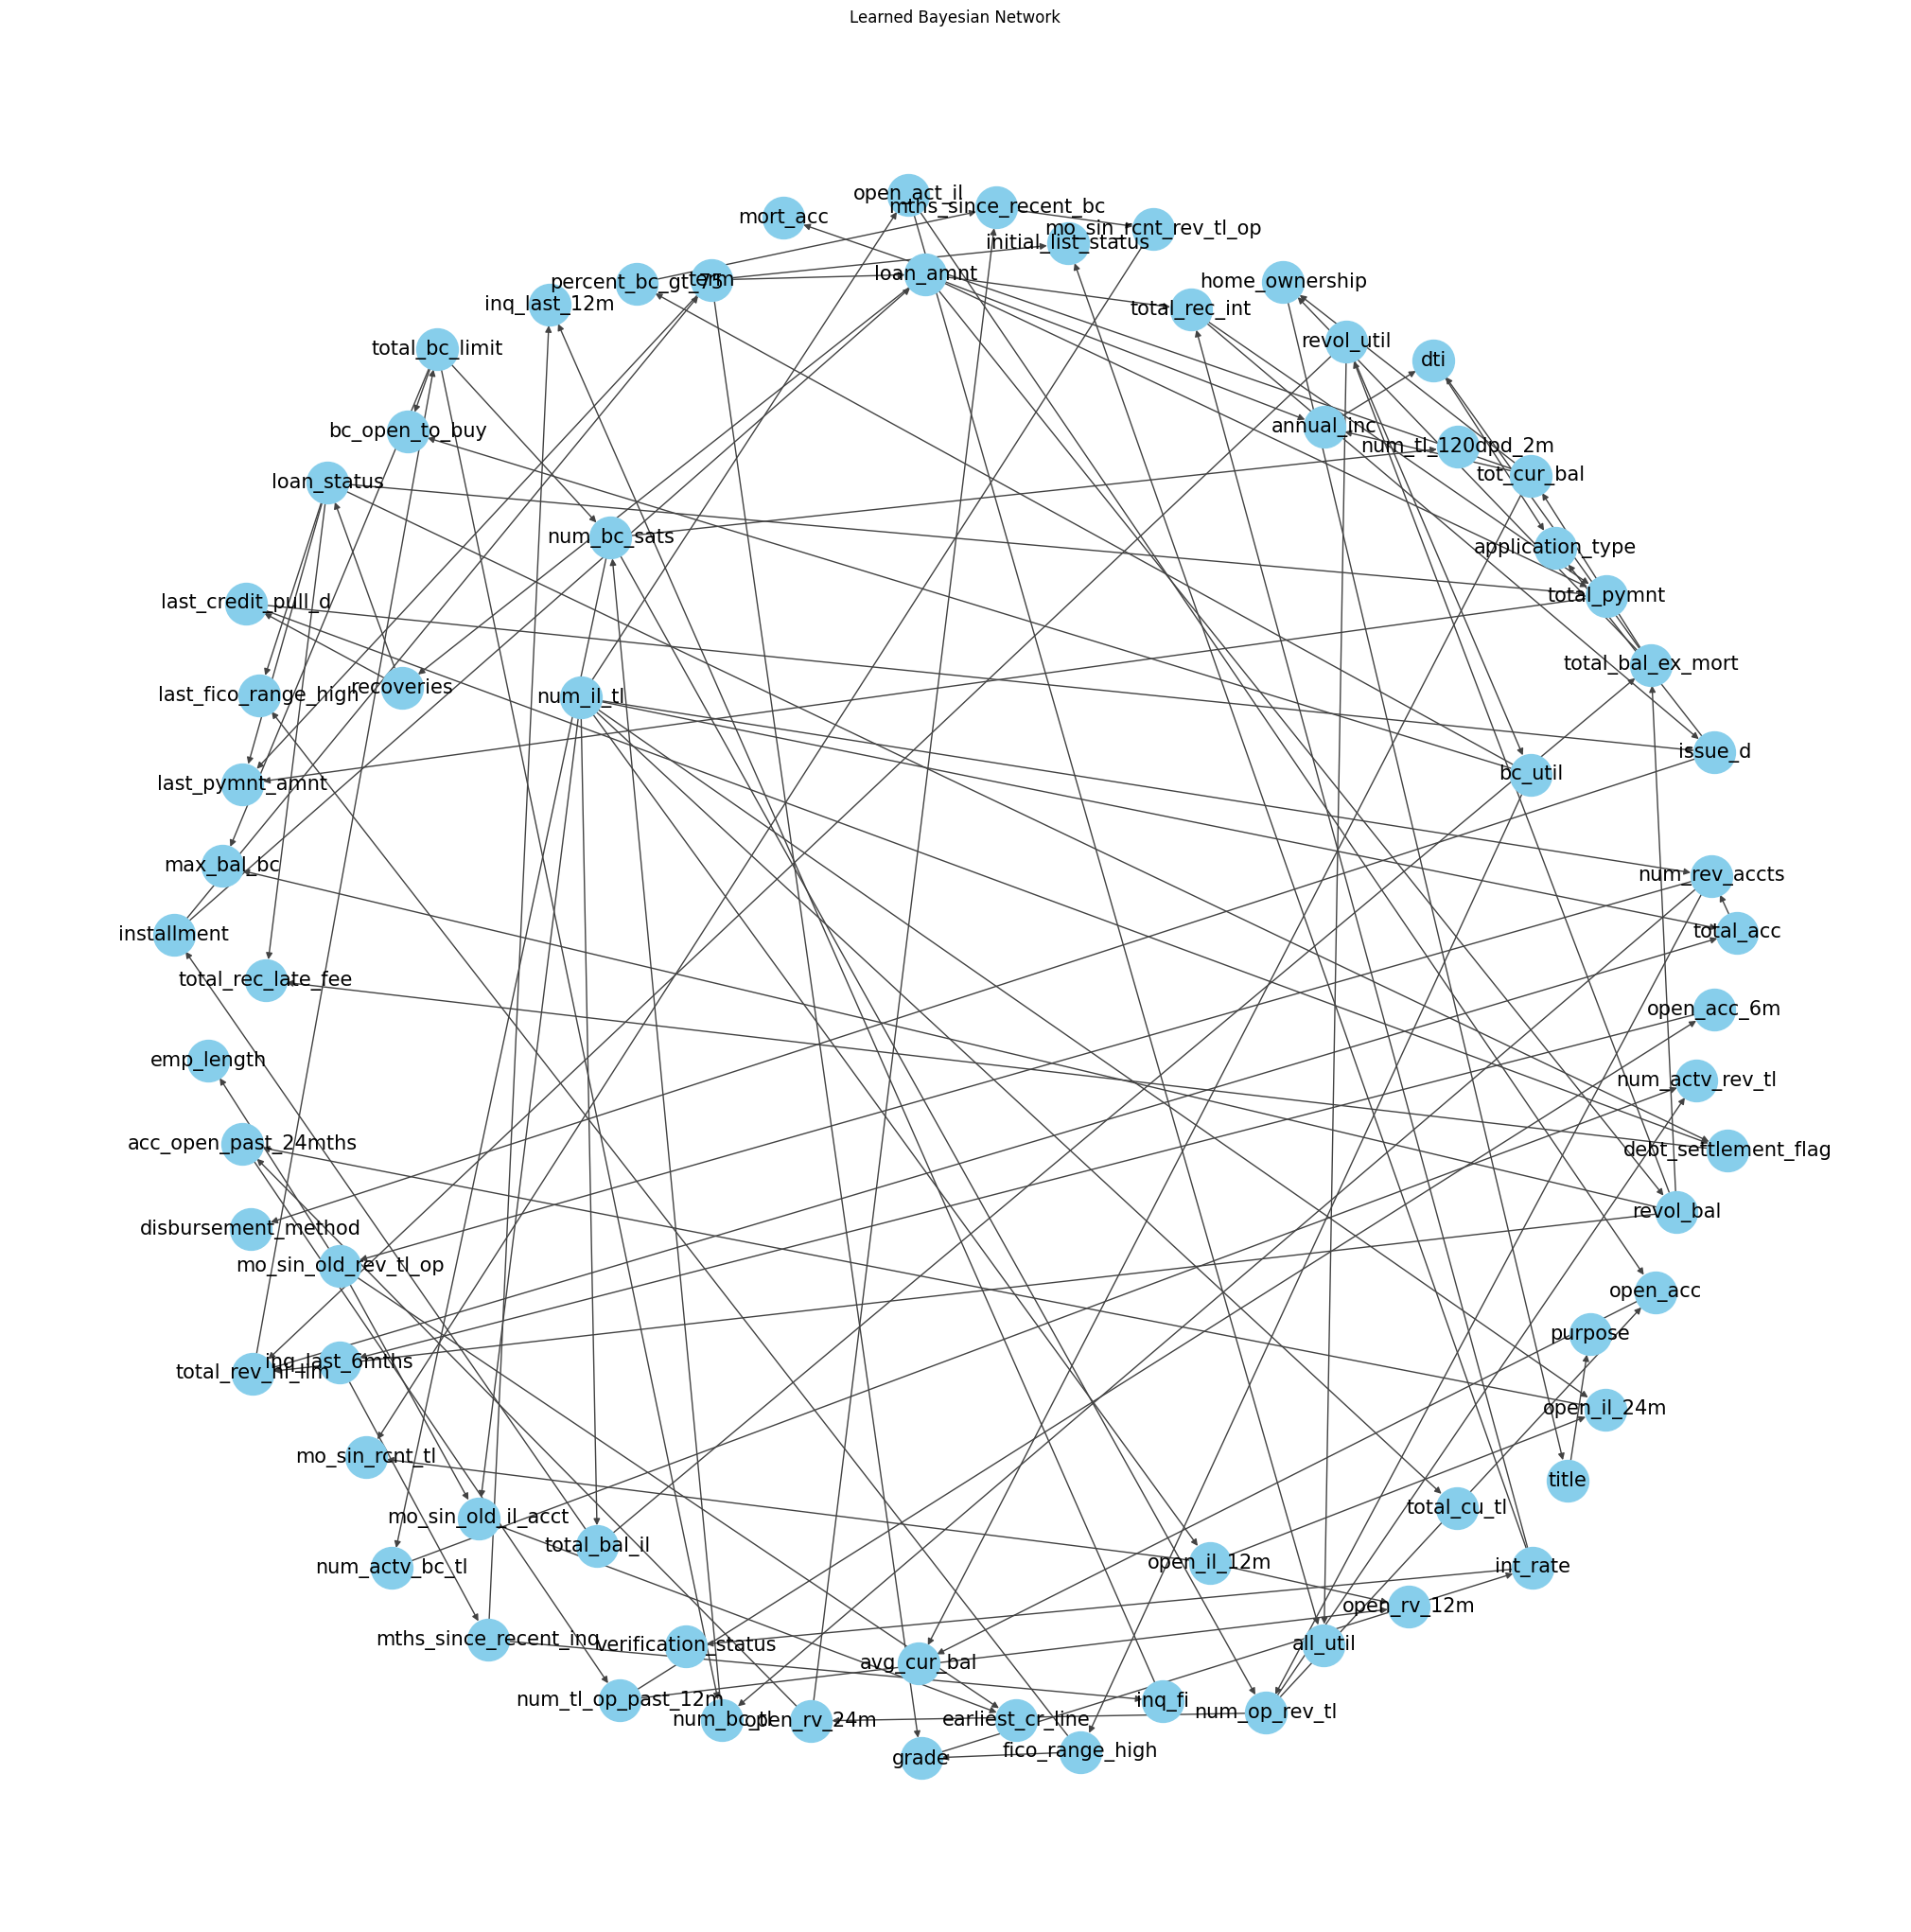

In [4]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
print(len(feature_states))
print(len(model.nodes()))
print(model.nodes())

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [5]:
parameter_estimator = estimators.BayesianEstimator(model,train_data, state_names = feature_states)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

model.states

{'loan_amnt': ['(961.0, 8800.0]',
  '(24400.0, 32200.0]',
  '(16600.0, 24400.0]',
  '(8800.0, 16600.0]',
  '(32200.0, 40000.0]'],
 'installment': ['(5.898, 350.054]',
  '(692.498, 1034.942]',
  '(350.054, 692.498]',
  '(1034.942, 1377.386]',
  '(1377.386, 1719.83]'],
 'term': [' 36 months', ' 60 months'],
 'total_pymnt': ['0.0', '3.0', '2.0', '1.0', '4.0'],
 'loan_status': ['Fully Paid', 'Charged Off'],
 'total_rec_int': ['0.0', '1.0', '2.0', '3.0', '4.0'],
 'int_rate': ['(10.446, 15.582]',
  '(20.718, 25.854]',
  '(5.284, 10.446]',
  '(15.582, 20.718]',
  '(25.854, 30.99]'],
 'revol_bal': ['0.0', '1.0', '2.0', '3.0', '4.0'],
 'recoveries': ['0.0', '1.0', '3.0', '2.0', '4.0'],
 'annual_inc': ['0.0', '1.0', '2.0', '3.0', '4.0'],
 'tot_cur_bal': ['1.0', '2.0', '0.0', '3.0', '4.0'],
 'grade': ['C', 'B', 'F', 'A', 'E', 'D', 'G'],
 'fico_range_high': ['(663.814, 701.2]',
  '(701.2, 738.4]',
  '(738.4, 775.6]',
  '(775.6, 812.8]',
  '(812.8, 850.0]'],
 'initial_list_status': ['w', 'f'],
 'la

### Inference

In [6]:
def performInference(target_label):
    y_pred = []
    y_true = []    
    testing_evidence_list = myData.get_evidence_list(test_data, target_label=target_label)
    inference = VariableElimination(model)
    for i in range(len(testing_evidence_list)):
        for attribute in list(testing_evidence_list[i].keys()):
            if attribute not in model.nodes():
                del testing_evidence_list[i][attribute]
                
    for i in range(len(testing_evidence_list)):
        loan_status = inference.map_query([target_label], evidence = testing_evidence_list[i], show_progress= True) 
        y_pred.append(loan_status[target_label])
        y_true.append(test_data[target_label].iloc[i])
    
    return y_pred, y_true
    
loan_status_y_pred, loan_status_y_true = performInference('loan_status')    


Eliminating: total_bal_ex_mort: 100%|██████████| 10/10 [00:00<00:00, 1895.30it/s]


## Testing

In [7]:
def testModel(y_true, y_pred):
    data_testing_corr_score = model.simulate(int(1e4))
    correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
    log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
    structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
    print("correlation score: " + str(correlation_score_value))
    print("Log likelihood score: " + str(log_likelihood_score_value))
    print("Structure score: "+ str(structure_score_value))

    accuracy_score_value = accuracy_score(y_true, y_pred)
    f1score_value = f1_score(y_true, y_pred, average = None)
    precisionScore = precision_score(y_true, y_pred,average = None)
    recallScore = recall_score(y_true, y_pred,average = None)
    #roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
    balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    precision_score_macro = precision_score(y_true, y_pred, average='macro')
    recall_score_macro = recall_score(y_true, y_pred, average='macro')

    f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
    precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
    recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

    print("accuracy score: "+str(accuracy_score_value))
    print("f1_score: "+str(f1score_value))
    print("precision score: "+str(precisionScore))
    print("recall score: "+str(recallScore))
    #print("roc auc score: "+str(roc_auc_score_value))
    print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
    print("\n\n")
    print("Macro scores:\n")
    print("recall_score_macro: "+str(recall_score_macro))
    print("f1_score_macro: "+str(f1_score_macro))
    print("precision_score_macro: "+str(precision_score_macro))
    print("\n")
    print("Weighted Scores:\n")
    print("recall_score_weighted: "+str(recall_score_weighted))
    print("f1_score_weighted: "+str(f1_score_weighted))
    print("precision_score_weighted: "+str(precision_score_weighted))
    
    
testModel(loan_status_y_true, loan_status_y_pred)

Generating for node: inq_last_12m: 100%|██████████| 69/69 [00:00<00:00, 118.51it/s]
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


correlation score: 0.0
Log likelihood score: -473531.73370142665
Structure score: -490533.8554230991
accuracy score: 0.8172
f1_score: [0.52246604 0.88696512]
precision score: [0.67024129 0.84297132]
recall score: [0.42808219 0.93580376]
balanced_accuracy_score: 0.36388594960963183



Macro scores:

recall_score_macro: 0.6819429748048159
f1_score_macro: 0.704715582307333
precision_score_macro: 0.7566063039864074


Weighted Scores:

recall_score_weighted: 0.8172
f1_score_weighted: 0.8018181386045672
precision_score_weighted: 0.8026215851096146
